In [64]:
import sys
import ee, geemap
import ipywidgets as widgets
import habitat_pl.viz.corine as corine
import importlib
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay

ee.Authenticate()
ee.Initialize(project='agh-ml-2025')
importlib.reload(corine)

# to keep things consistent
RANDOM_SEED = 123
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [ ]:
szpn_geom = ee.Geometry.Polygon(
       [[19.4, 49.3], [19.4, 50.1], [20.6, 50.1], [20.6, 49.3], [19.4, 49.3]]
)
region = ee.FeatureCollection([ee.Feature(szpn_geom)])

# Annual Satellite Embedding (example: 2021)
emb = (ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
       .filterDate('2021-05-01','2021-07-01')
       .filterBounds(region)
       .mosaic()
       .clip(region))

# Visualize (pseudo-RGB from embedding bands)
m = geemap.Map()
m.centerObject(region, 8)
m.addLayer(emb, {'min':-0.3,'max':0.3,'bands':['A01','A16','A09']}, 'Embeddings 2021')

# Loads CORINE Land Cover 2018 raster (44 classes, 100 m resolution).
clc = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(region)

# Remaps CORINE class codes (111…523) to sequential indices (1…44).
clc_idx = clc.remap(corine.codes, list(range(1, len(corine.codes)+1))).rename('landcover_idx')

In [66]:
# Get GSE samples from 2021 (same as map visualization)
gse_2021 = (ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
            .filterDate('2021-01-01', '2022-01-01')
            .filterBounds(region)
            .mosaic()
            .clip(region))

gse_bands = [b for b in gse_2021.bandNames().getInfo() if b.startswith('A')]

# Extract CORINE labels for the same region
corine_data = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(region)
# Remap CORINE codes to sequential indices
corine_idx = corine_data.remap(corine.codes, list(range(1, len(corine.codes)+1))).rename('landcover_idx')
# Delete pixels with no data
gse_masked = gse_2021.updateMask(corine_idx.gt(0))

print(f"✓ GSE and CORINE data extracted for AOI")

✓ GSE and CORINE data extracted for AOI


In [67]:
# CORINE forest classes
FOREST_CODES = [311, 312, 313]

# Create forest-only mask
forest_mask = corine_data.remap(
    FOREST_CODES,
    [1, 2, 3]   # map to class indices
).rename('forest_class')

# Mask embeddings to forest pixels only
gse_forest = gse_2021.updateMask(forest_mask.gt(0))

print("✓ Forest-only embeddings created")


✓ Forest-only embeddings created


In [68]:
# Stack embeddings and labels
stack = gse_forest.select(gse_bands).addBands(forest_mask)

# Random spatial sampling
samples = stack.stratifiedSample(
    numPoints=1500,          # PER CLASS
    classBand='forest_class',
    region=region.geometry(),
    scale=100,
    seed=RANDOM_SEED,
    geometries=False
)


print("✓ Samples collected:", samples.size().getInfo())


✓ Samples collected: 0


In [69]:
# Convert to client-side
samples_fc = samples.getInfo()

# Extract feature matrix and labels
X = []
y = []

for f in samples_fc['features']:
    props = f['properties']
    X.append([props[b] for b in gse_bands])
    y.append(props['forest_class'] - 1)  # 0,1,2

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Check class distribution
unique, counts = np.unique(y, return_counts=True)
print("\nClass distribution:")
class_names = ['Broadleaf (311)', 'Coniferous (312)', 'Mixed (313)']
for cls, count, name in zip(unique, counts, class_names):
    print(f"  {name}: {count} samples ({count/len(y)*100:.1f}%)")


X shape: (0,)
y shape: (0,)

Class distribution:


In [70]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
## variables for dimensionality reduction
TSNE_PERPLEXITY = 30
UMAP_N_NEIGHBORS = 10
UMAP_MIN_DIST = 0.1


# PCA (2D)
pca_2d = PCA(n_components=2, random_state=RANDOM_SEED).fit_transform(X)

# t-SNE (2D)
tsne_2d = TSNE(n_components=2, perplexity=TSNE_PERPLEXITY, learning_rate='auto',
               init='pca', random_state=RANDOM_SEED).fit_transform(X)

# UMAP (2D)
umap_2d = umap.UMAP(n_neighbors=UMAP_N_NEIGHBORS, min_dist=UMAP_MIN_DIST,
                    n_components=2, metric='euclidean', random_state=RANDOM_SEED).fit_transform(X)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

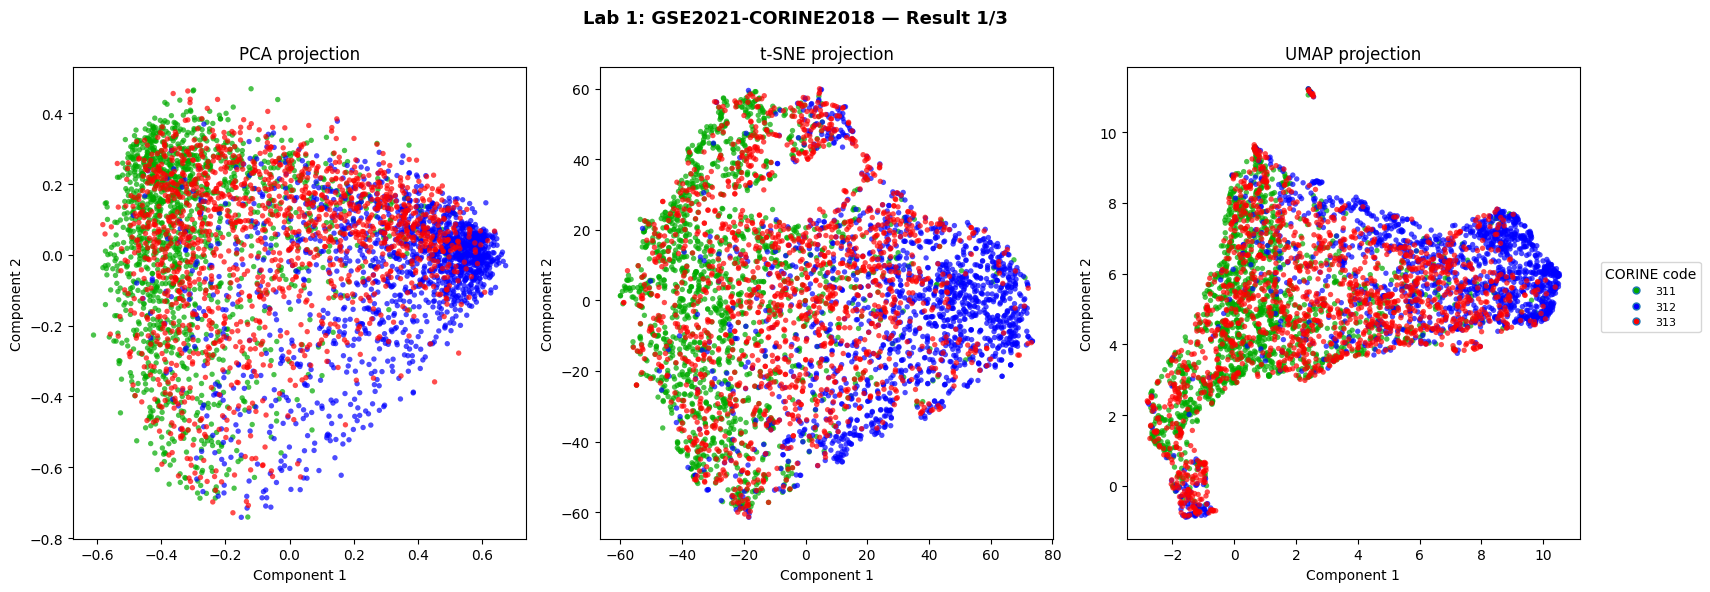

In [ ]:
FOREST_CLASS_CODES = [311, 312, 313]  # Broadleaf, Coniferous, Mixed
idx_to_color = {0: '#00AA00', 1: '#0000FF', 2: '#FF0000'}  # green, blue, red
idx_to_code = {i: code for i, code in enumerate(FOREST_CLASS_CODES)}
code_to_name = {311: 'Broad-leaved forest', 312: 'Coniferous forest', 313: 'Mixed forest'}

unique_idx = sorted(np.unique(y))

# Plotting with code-only labels
fig, axes = plt.subplots(1, 3, figsize=(16, 6), dpi=100)
for ax, xy, name in zip(
    axes,
    [pca_2d, tsne_2d, umap_2d],
    ['PCA projection','t-SNE projection','UMAP projection']
):
    for cls in unique_idx:
        m = (y == cls)
        if not m.any():
            continue
        ax.scatter(
            xy[m, 0], xy[m, 1],
            s=15, alpha=0.7,
            color=idx_to_color.get(cls, '#000000'),
            edgecolors='none'
        )
    ax.set_title(name, fontsize=12)
    ax.set_xlabel('Component 1', fontsize=10)
    ax.set_ylabel('Component 2', fontsize=10)
    ax.grid(False)

handles, labels = [], []
for cls in unique_idx:
    handles.append(plt.Line2D([0],[0], marker='o', linestyle='',
                              markersize=5, markerfacecolor=idx_to_color.get(cls, '#000000')))
    labels.append(str(idx_to_code.get(cls, cls)))
fig.legend(handles, labels, title="CORINE code", bbox_to_anchor=(1.0, 0.5), 
           loc='center left', fontsize=8, ncol=1)

fig.suptitle("Lab 1: GSE2021-CORINE2018 — Result 1/3", fontsize=13, weight='bold')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xn = scaler.fit_transform(X)

# PCA (2D)
Xp = PCA(n_components=2, random_state=RANDOM_SEED).fit_transform(Xn)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

Xtr, Xte, ytr, yte = train_test_split(
    Xn, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_SEED
)

svm = SVC(kernel='rbf', C=100, gamma=0.001, random_state=RANDOM_SEED)
svm.fit(Xtr, ytr)

yp = svm.predict(Xte)

print("Accuracy:", svm.score(Xte, yte))
print(classification_report(yte, yp))


Accuracy: 0.6511111111111111
              precision    recall  f1-score   support

           0       0.70      0.68      0.69       300
           1       0.75      0.74      0.74       300
           2       0.51      0.53      0.52       300

    accuracy                           0.65       900
   macro avg       0.65      0.65      0.65       900
weighted avg       0.65      0.65      0.65       900



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest often performs better with high-dimensional data
rf = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=5, 
                            random_state=RANDOM_SEED, n_jobs=-1)
rf.fit(Xtr, ytr)

print("Random Forest accuracy:", rf.score(Xte, yte))
yp_rf = rf.predict(Xte)
print(classification_report(yte, yp_rf))

Random Forest accuracy: 0.6444444444444445
              precision    recall  f1-score   support

           0       0.66      0.71      0.68       300
           1       0.76      0.74      0.75       300
           2       0.51      0.48      0.49       300

    accuracy                           0.64       900
   macro avg       0.64      0.64      0.64       900
weighted avg       0.64      0.64      0.64       900



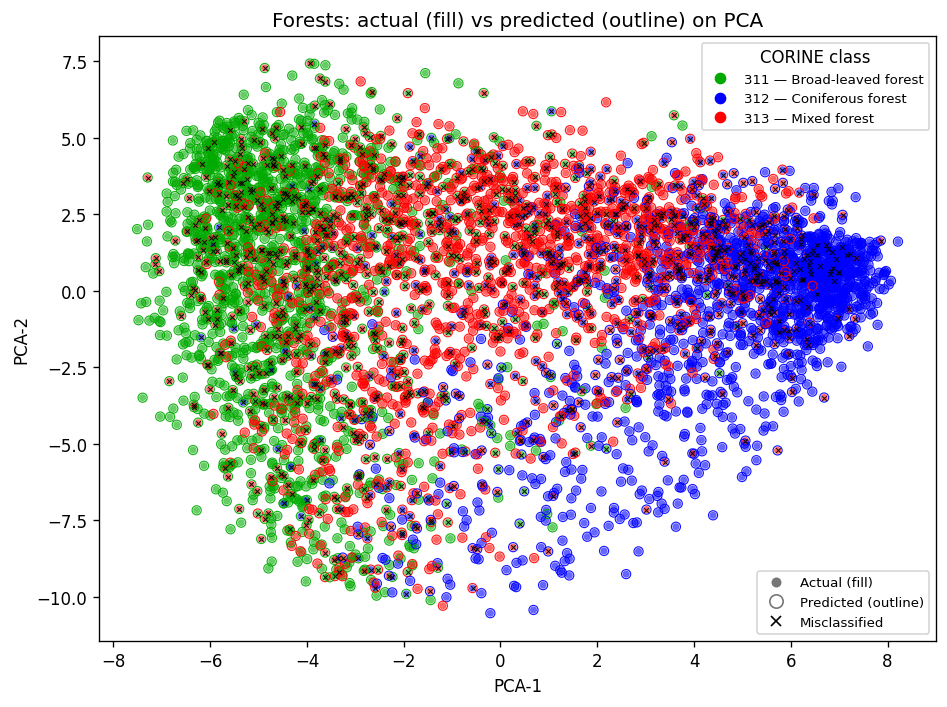

In [ ]:
# Visualize forests: actual (fill) vs predicted (outline) on PCA
# Uses existing variables: Xp, Xn, y, svm, idx_to_color, idx_to_code, code_to_name

# Predict all points using the trained SVM
y_pred_all = svm.predict(Xn)

# Colors for actual and predicted
actual_colors = [idx_to_color[int(c)] for c in y]
pred_colors = [idx_to_color[int(c)] for c in y_pred_all]

# Plot
fig_vis, ax_vis = plt.subplots(figsize=(8, 6), dpi=120)

# Actual labels as filled circles
ax_vis.scatter(
    Xp[:, 0], Xp[:, 1],
    c=actual_colors, s=18, alpha=0.6, marker='o', linewidths=0
)

# Predicted labels as outlines
ax_vis.scatter(
    Xp[:, 0], Xp[:, 1],
    facecolors='none', edgecolors=pred_colors, s=30, alpha=0.9, marker='o', linewidths=0.7
)

# Highlight misclassifications
mis = y_pred_all != y
if mis.any():
    ax_vis.scatter(
        Xp[mis, 0], Xp[mis, 1],
        c='black', s=8, marker='x', linewidths=0.6, alpha=0.9
    )

ax_vis.set_title('Forests: actual (fill) vs predicted (outline) on PCA', fontsize=12)
ax_vis.set_xlabel('PCA-1', fontsize=10)
ax_vis.set_ylabel('PCA-2', fontsize=10)
ax_vis.grid(False)

# Legends
class_handles, class_labels = [], []
for cls in sorted(set(y)):
    color = idx_to_color[int(cls)]
    code = idx_to_code[int(cls)]
    name = code_to_name.get(code, str(code))
    class_handles.append(plt.Line2D([0], [0], marker='o', linestyle='', markersize=6,
                                    markerfacecolor=color, markeredgecolor=color))
    class_labels.append(f'{code} — {name}')
legend_classes = ax_vis.legend(class_handles, class_labels, title='CORINE class', loc='upper right', fontsize=8)

style_handles = [
    plt.Line2D([0], [0], marker='o', linestyle='', markersize=6,
               markerfacecolor='#777777', markeredgecolor='none', label='Actual (fill)'),
    plt.Line2D([0], [0], marker='o', linestyle='', markersize=8,
               markerfacecolor='none', markeredgecolor='#777777', label='Predicted (outline)'),
    plt.Line2D([0], [0], marker='x', linestyle='', markersize=6,
               markeredgecolor='black', markerfacecolor='black', label='Misclassified')
]
legend_styles = ax_vis.legend(handles=style_handles, loc='lower right', fontsize=8)
ax_vis.add_artist(legend_classes)

plt.tight_layout()
plt.show()

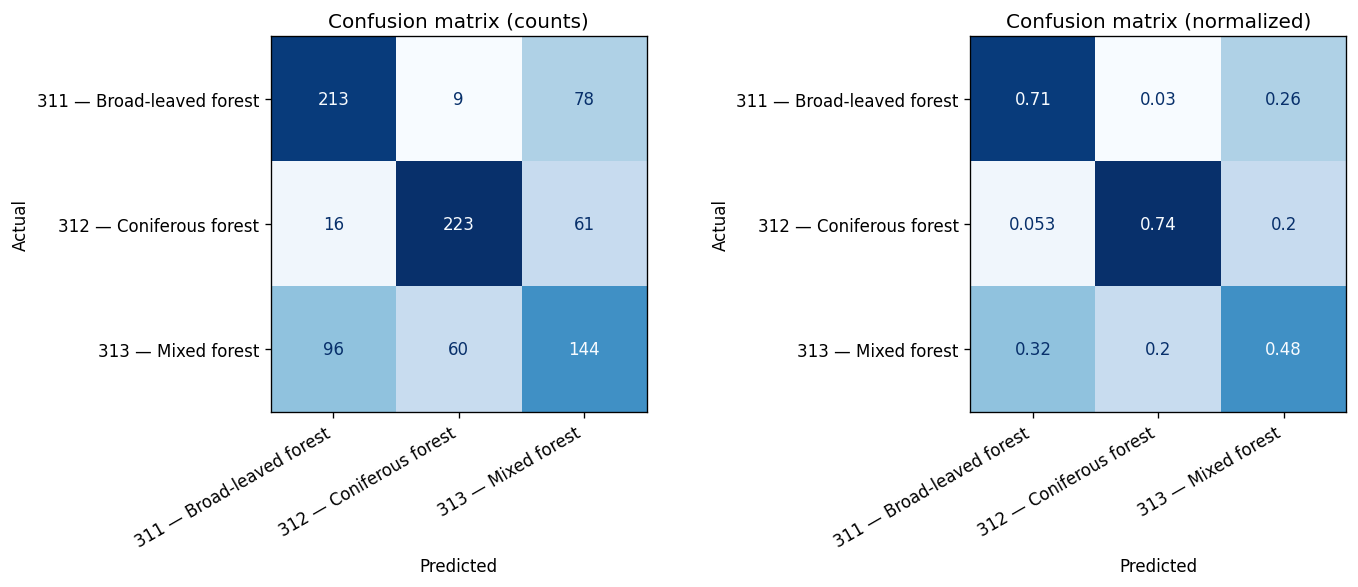

In [ ]:
# Use ConfusionMatrixDisplay from sklearn.metrics to visualize confusion matrices

classes_idx = [int(c) for c in unique_idx]
class_labels = [f"{idx_to_code[i]} — {code_to_name.get(idx_to_code[i], str(idx_to_code[i]))}" for i in classes_idx]

# Choose the predictions to analyze (use yp_rf; switch to yp_tuned or yp_xgb if needed)
y_pred = yp_rf

fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=120)

# Raw counts
ConfusionMatrixDisplay.from_predictions(
    yte, y_pred,
    labels=classes_idx,
    display_labels=class_labels,
    ax=axes[0],
    cmap='Blues',
    colorbar=False
)
axes[0].set_title('Confusion matrix (counts)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Normalized by true class (recall per class)
ConfusionMatrixDisplay.from_predictions(
    yte, y_pred,
    labels=classes_idx,
    display_labels=class_labels,
    normalize='true',
    ax=axes[1],
    cmap='Blues',
    colorbar=False
)
axes[1].set_title('Confusion matrix (normalized)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

for ax in axes:
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()